In [1]:
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from time import time
import re
import spacy
import markovify
import warnings
import en_core_web_sm
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

C:\Users\jonat\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Get data and images I need


In [2]:
%cd C:\Users\jonat\Desktop\NLP

C:\Users\jonat\Desktop\NLP


In [3]:
img = np.array(Image.open("Trump.png"))
df = pd.read_csv(r'realdonaldtrump.csv')

# Gotta get some sweet functions to make my life easier

In [4]:
def preprocess(docs):
  lemmatizer = WordNetLemmatizer()
  stemmer = SnowballStemmer('english')
  preprocessed = []

  for doc in docs:


    tokenized = word_tokenize(doc)
    # list comprehension
    # cleaned = [stemmer.stem(lemmatizer.lemmatize(token.lower())) 
    #             for token in tokenized 
    #             if token.lower() not in stopwords.words('english') 
    #             if token.isalpha()]

    cleaned = []
    for token in tokenized:
      if token.lower() not in stopwords.words('english') and token.isalpha():
        lemmatized = lemmatizer.lemmatize(token.lower())
        stemmed = stemmer.stem(lemmatized)
        cleaned.append(stemmed)
    


    # combine the list into a big string
    untokenized = ' '.join(cleaned)
    preprocessed.append(untokenized)

  return preprocessed
def text_stats(doc):
    sents = sent_tokenize(doc)
    tokens = word_tokenize(doc)
    words = [token.lower() for token in tokens 
             if not token.lower() in stopwords.words('english')
             if not token in string.punctuation]

    num_sents = len(sents)
    num_tokens = len(tokens)
    num_words = len(words)
    vocab = len(set(words))
    characters = sum([len(word) for word in words])
    
    spacy_doc = nlp(doc)
    remove = ['DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 
              'ORDINAL', 'CARDINAL']
    entities = [entity.text for entity in spacy_doc.ents 
                if not entity.label_ in remove]

    num_entities = len(set(entities))
    words_sent = num_words / num_sents
    char_word = characters / num_words
    lex_div = vocab / num_words
    
    stats = [num_sents, num_tokens, num_words, vocab, num_entities, 
             words_sent, char_word, lex_div]

    return stats
def word_cloud(text, colormap='tab10', background_color='white'):
    cloud = WordCloud(width=1600, height=800, stopwords=STOPWORDS,
                      colormap=colormap, 
                      background_color=background_color).generate(text)
    
    plt.figure(figsize=(12,10))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


In [5]:
#Getting only the tweets
tweets = list(df['content'])


In [6]:
#Making a string of tweets and removing any hyperlinks as well as mentions of twitter on twitter
maga = ""
for tweet in tweets:
    maga+=tweet
maga = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', maga)
maga = maga.replace("twitter", "")

In [7]:
nlp = en_core_web_sm.load()
#Don't want to exceed the parser limit, this guy really does tweet a lot. My gosh!
maga_doc = nlp(maga[:(1000000-1)])


In [8]:
maga_sents = " ".join([sent.text for sent in maga_doc.sents if len(sent.text) > 1])
maga_sents

'Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:  - Very funny!New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way:  persona will never be that of a wallflower - I’d rather build walls than cling to them" --Donald J. TrumpMiss USA Tara Conner will not be fired - "I\'ve always been a believer in second chances." says Donald TrumpListen to an interview with Donald Trump discussing his new book, Think Like A Champion:  for wholeness and keep your sense of wonder intact." --Donald J. Trump  the "Think Like A Champion" signed book and keychain contest:   the achiever achieves, it\'s not a plateau, it’s a beginning." --Donald J. Trump  be afraid of being unique - it\'s like being afraid of your 

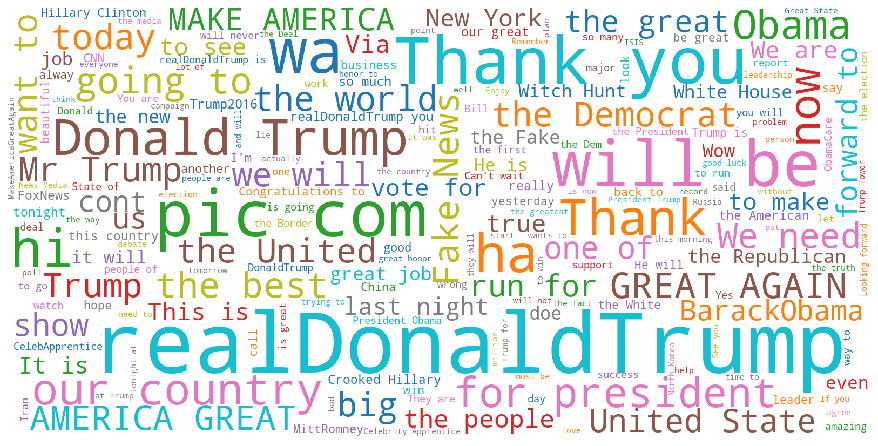

In [9]:
#Make a pretty word cloud for presentation sake since it looks cool
word_cloud(maga)


In [10]:
wc = WordCloud(width=1600, height=800, stopwords=STOPWORDS,
                      background_color="black", max_words = 1000, mask = img).generate(maga)

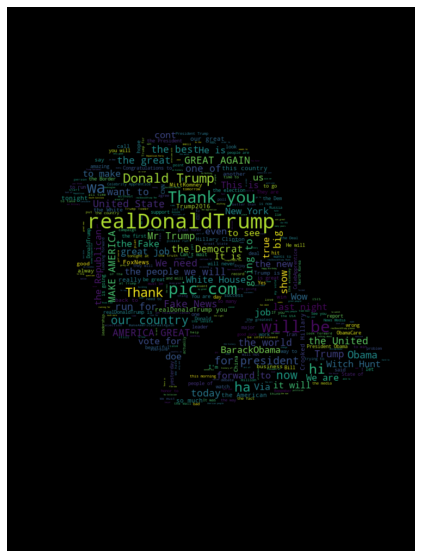

In [11]:
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
tweets[0]

'Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!'

In [13]:
#Due to this length, I'm only going to use 10k tweets rather than all of them. I want to not spend a ton of time processing this. 
#Using spark/hadoop might help with this, but that is something for another day
len(tweets)

42295

In [14]:
#This is 10k tweets. I'm pretty sure that's more than enough data
preprocessed = preprocess(tweets[32294:42294])

# Do a few types of vectorization to make vectors for the spectors

In [15]:
#Count Vectorize
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(preprocessed)

count = pd.DataFrame(vectors.toarray(), 
                     columns=vectorizer.get_feature_names())
count.head(10)

,aaa,abandon,abba,abbott,abc,abcnew,abcworldnew,abduct,abdul,abdullah,...,گوید,یا,یابند,इस,एक,और,कर,यह,हम,हर
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#One hot 
vectorizer = CountVectorizer(binary=True)
vectors = vectorizer.fit_transform(preprocessed)

one_hot = pd.DataFrame(vectors.toarray(), 
                     columns=vectorizer.get_feature_names())
one_hot.head(10)

,aaa,abandon,abba,abbott,abc,abcnew,abcworldnew,abduct,abdul,abdullah,...,گوید,یا,یابند,इस,एक,और,कर,यह,हम,हर
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#TF-IDF 
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(preprocessed)

tfidf = pd.DataFrame(vectors.toarray(), 
                     columns=vectorizer.get_feature_names())

tfidf.describe()

,aaa,abandon,abba,abbott,abc,abcnew,abcworldnew,abduct,abdul,abdullah,...,گوید,یا,یابند,इस,एक,और,कर,यह,हम,हर
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.000039,0.000380,0.000043,0.000029,0.000699,0.000058,0.000030,0.000040,0.000037,0.000043,...,0.000020,0.000029,0.000011,0.000028,0.000028,0.000263,0.000028,0.000026,0.000146,0.000028
std,0.003857,0.010836,0.004325,0.002899,0.015270,0.004078,0.002975,0.003954,0.003707,0.004280,...,0.002034,0.002044,0.001095,0.002802,0.002802,0.015260,0.002802,0.002603,0.011002,0.002802
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.385696,0.446319,0.432537,0.289918,0.526086,0.290607,0.297518,0.395354,0.370679,0.428046,...,0.203438,0.159375,0.109533,0.280201,0.280201,0.965517,0.280201,0.260340,1.000000,0.280201


# Honestly, given the task, this step doesn't seem as useful.

### Were I using this text to predict something, then I'm using different models(Logreg, RandomForestClassifier, GBC) would show the differences between these vectorizing methods. BoW is a good general method, tf-idf gives words wights so it's better with distinctive words whereas word-vec produces a vector per word(rather than BoW wordcount)

# Now let's see if I can make sentences that can seem like something Trump wrote!

In [18]:
trump_generator = markovify.Text(maga_sents, state_size = 3)

In [19]:
for i in range(5):
    print(trump_generator.make_sentence())
    print("---------------------------------------")

@ RNC will regret being soft on @ BarackObama will create over $12T in new debt.
---------------------------------------
Very sad & their bloggers are doing even worse!My @ FoxBusiness interview on @ gretawire discussing the @ nyjets yesterday.
---------------------------------------
It is a great group.
---------------------------------------
Dianne Gallagher @ DianneG is a great athlete but less than average quarterback.
---------------------------------------
It's going to get any of the battleground states.
---------------------------------------
